In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: Precompiling FundamentalsNumericalComputation [e48b7b93-d2a8-4750-aba7-f743ccd5256c]
└ @ Base loading.jl:1423
[ Info: Re-exporting multiple packages...
[ Info: verify download of index files...
[ Info: reading database
[ Info: adding metadata...
[ Info: adding svd data...
[ Info: writing database
[ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote site

(section-advection-wave)=
# The wave equation

```{index} ! wave equation
```
Closely related to the advection equation is the **wave equation**,

:::{math}
  :label: wavepde
    u_{tt} - c^2 u_{xx} = 0.
:::

This is our first PDE having a second derivative in time. As in the advection equation, $u(x,t)=\phi(x-ct)$ is a solution of {eq}`wavepde`, but now so is $u(x,t)=\phi(x+c t)$ for any twice-differentiable $\phi$ (see [Exercise 2](problem-wave-twodir)). Thus, the wave equation supports advection in both directions simultaneously. 

We will use $x \in [0,1]$ and $t>0$ as the domain. Because $u$ has two derivatives in $t$ and in $x$, we need two boundary conditions. We will use the Dirichlet conditions  

:::{math}
:label: waveBC
u(0,t) = u(1,t) = 0, \qquad t \ge 0,
:::

and two initial conditions,

:::{math}
:label: waveIC
u(x,0) &= f(x), \qquad 0 \le x \le 1,  \\
u_t(x,0) &= g(x), \qquad 0 \le x \le 1. 
:::

One approach is to discretize both the $u_{tt}$ and $u_{xx}$ terms using finite differences:

$$
\frac{1}{\tau^2}(U_{i,j+1} - 2U_{i,j} + U_{i,j-1}) = \frac{c^2}{h^2}
(U_{i+1,j} - 2U_{i,j} + U_{i-1,j}).
$$

This equation can be rearranged to solve for $U_{i,j+1}$ in terms of values at time levels $j$ and $j-1$. Rather than pursue this method, however, we will turn to the method of lines.

## First-order system

In order to be compatible with the standard IVP solvers that we have encountered, we must recast {eq}`wavepde` as a first-order system in time. Using our typical methodology, we would define $y=u_t$ and derive

:::{math}
:label: wavefirst1
\begin{split}
  u_t &= y, \\
  y_t &= c^2 u_{xx}.
\end{split}
:::

However, there is another, less obvious option for reducing to a first-order system:

:::{math}
  :label: wavefirst2
    u_t &= z_x, \\
    z_t &= c^2 u_{x}.
:::

```{index} Maxwell's equations
```

This second form is appealing in part because it's equivalent to Maxwell's equations for electromagnetism. In the Maxwell form we typically replace the velocity initial condition in {eq}`waveIC` with a condition on $z$, which may be physically more relevant in some applications:

:::{math}
:label: waveIC2
u(x,0) &= f(x), \qquad 0 \le x \le 1,  \\
z(x,0) &= g(x), \qquad 0 \le x \le 1.
:::

Because waves travel in both directions, there is no preferred upwind direction. This makes a centered finite difference in space appropriate. Before application of the boundary conditions, semidiscretization of {eq}`wavefirst2` leads to

:::{math}
  :label: waveMOL
  \begin{bmatrix}
    \mathbf{u}'(t) \\[2mm]  \mathbf{z}'(t)
  \end{bmatrix}
  =
  \begin{bmatrix}
    \boldsymbol{0} & \mathbf{D}_x \\[2mm] c^2 \mathbf{D}_x & \boldsymbol{0}
  \end{bmatrix}
  \begin{bmatrix}
    \mathbf{u}(t) \\[2mm] \mathbf{z}(t)
  \end{bmatrix}.
:::

The boundary conditions {eq}`waveBC` suggest that we should remove both of the end values of $\mathbf{u}$ from the discretization, but retain all of the $\mathbf{z}$ values. We use $\mathbf{w}(t)$ to denote the vector of all the unknowns in the semidiscretization. When computing $\mathbf{w}'(t)$, we extract the $\mathbf{u}$ and $\mathbf{z}$ components, and we use dedicated functions for padding with the zero end values or chopping off the zeros as necessary.

(demo-wave-boundaries)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve the wave equation {eq}`wavefirst2` with speed $c=2$, subject to {eq}`waveBC` and initial conditions {eq}`waveIC2`.

In [2]:
m = 200
x,Dₓ = FNC.diffcheb(m,[-1,1]);

The boundary values of $u$ are given to be zero, so they are not unknowns in the ODEs. Instead they are added or removed as necessary.

In [3]:
extend = v -> [0;v;0]
chop = u -> u[2:m];

The following function computes the time derivative of the system at interior points.

In [4]:
ode = function(w,c,t)
    u = extend(w[1:m-1])
    z = w[m:2m]
    dudt = Dₓ*z
    dzdt = c^2*(Dₓ*u)
    return [ chop(dudt); dzdt ]
end;

Our initial condition is a single hump for $u$.

In [5]:
u_init = @. exp(-100*(x+0.5)^2)
z_init = -u_init
w_init = [ chop(u_init); z_init ];  

Because the wave equation is hyperbolic, we can use a nonstiff explicit solver.

In [6]:
IVP = ODEProblem(ode,w_init,(0.,2.),2)
w = solve(IVP,RK4());

We plot the results for the original $u$ variable only. Its interior values are at indices `1:m-1` of the composite $\mathbf{w}$ variable.

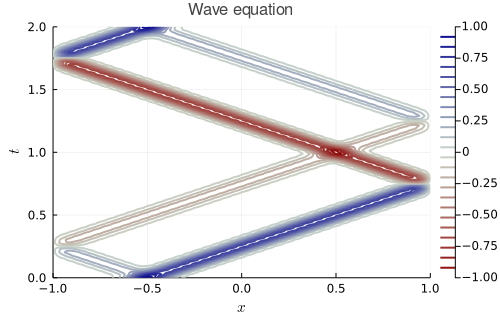

In [7]:
t = range(0,2,length=80)
U = [extend(w(t)[1:m-1]) for t in t]
contour(x,t,hcat(U...)',color=:redsblues,clims=(-1,1),
    levels=24,xlabel=L"x",ylabel=L"t",title="Wave equation",
    right_margin=3Plots.mm)

In [8]:
anim = @animate for t in range(0,2,length=120)
    plot(x,extend(w(t)[1:m-1]),label=@sprintf("t=%.3f",t),
        xaxis=(L"x"),yaxis=([-1,1],L"u(x,t)"),dpi=100,    
        title="Wave equation")
end
mp4(anim,"figures/wave-boundaries.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/repos/fnc-julia/advection/figures/wave-boundaries.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/advection/figures/wave-boundaries.mp4")

The original hump breaks into two pieces of different amplitudes, each traveling with speed $c=2$. They pass through one another without interference. When a hump encounters a boundary, it is perfectly reflected, but with inverted shape. At time $t=2$, the solution looks just like the initial condition.


```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Variable speed

An interesting situation is when the wave speed $c$ changes discontinuously, as when light passes from one material into another. For this we must replace the term $c^2$ in {eq}`waveMOL` with the matrix $\operatorname{diag}\bigl(c^2(x_0),\ldots,c^2(x_m)\bigr)$.

(demo-wave-speed)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We now use a wave speed that is discontinuous at $x=0$; to the left, $c=1$, and to the right, $c=2$. The ODE implementation has to change slightly.

In [9]:
ode = function(w,c,t)
    u = extend(w[1:m-1])
    z = w[m:2m]
    dudt = Dₓ*z
    dzdt = c.^2 .* (Dₓ*u)
    return [ chop(dudt); dzdt ]
end;

The variable wave speed is passed as an extra parameter through the IVP solver.

In [10]:
c = @. 1 + (sign(x)+1)/2
IVP = ODEProblem(ode,w_init,(0.,5.),c)
w = solve(IVP,RK4());

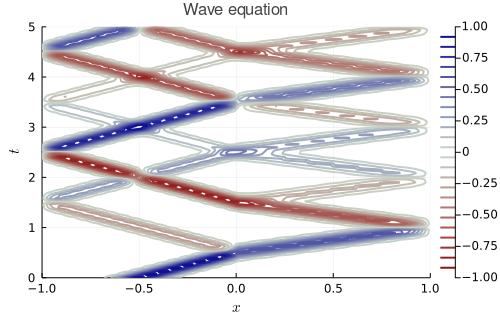

In [11]:
t = range(0,5,length=80)
U = [extend(w(t)[1:m-1]) for t in t]
contour(x,t,hcat(U...)',color=:redsblues,clims=(-1,1),
    levels=24,xlabel=L"x",ylabel=L"t",title="Wave equation",
    right_margin=3Plots.mm)

In [12]:
anim = @animate for t in range(0,5,length=181)
    plot(Shape([-1,0,0,-1],[-1,-1,1,1]),color=RGB(.8,.8,.8),l=0,label="")
    plot!(x,extend(w(t,idxs=1:m-1)),label=@sprintf("t=%.2f",t),
        xaxis=(L"x"),yaxis=([-1,1],L"u(x,t)"),dpi=100,   
        title="Wave equation, variable speed" )
end
mp4(anim,"figures/wave-speed.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/repos/fnc-julia/advection/figures/wave-speed.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/Users/driscoll/repos/fnc-julia/advection/figures/wave-speed.mp4")

Each pass through the interface at $x=0$ generates a reflected and transmitted wave. By conservation of energy, these are both smaller in amplitude than the incoming bump.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Exercises

1. ✍ Consider the Maxwell equations {eq}`wavefirst2` with smooth solution $u(x,t)$ and $z(x,t)$.

    **(a)** Show that $u_{tt} = c^2 u_{xx}$.
    
    **(b)** Show that $z_{tt} = c^2 z_{xx}$.

    (problem-wave-twodir)=
2. ✍ Suppose that $\phi(s)$ is any twice-differentiable function.
    
    **(a)** Show that $u(x,t) = \phi(x-c t)$ is a solution of $u_{tt}=c^2u_{xx}$. (As in the advection equation, this is a traveling wave of velocity $c$.)

    **(b)** Show that $u(x,t) = \phi(x+c t)$ is another solution of $u_{tt}=c^2u_{xx}$. (This is a traveling wave of velocity $-c$.)

    ```{index} D'Alembert's solution
    ```
3. ✍ Show that the following is a solution to the wave equation $u_{tt}=c^2u_{xx}$ with initial and boundary conditions {eq}`waveBC` and {eq}`waveIC`:

    $$
    u(x,t) = \frac{1}{2} \left[ f(x-ct)+f(x+ct)\right] + \frac{1}{2c} \int_{x-ct}^{x+ct} g(\xi) \, d\xi
    $$
    
    This is known as *D'Alembert's solution*.
    
4. ⌨ Suppose the wave equation has homogeneous Neumann conditions on $u$ at each boundary instead of Dirichlet conditions. Using the Maxwell formulation {eq}`wavefirst2`, we have $z_t=c^2u_x$, so $z$ is constant in time at each boundary. Therefore, the endpoint values of $\mathbf{z}$ can be taken from the initial condition and removed from the ODE, while the entire $\mathbf{u}$ vector is now part of the ODE. 
   
    Modify {numref}`Demo {number} <demo-wave-boundaries>` to solve the PDE there with Neumann instead of Dirichlet conditions, and make an animation or space-time portrait of the solution. In what major way is it different from the Dirichlet case?

5. ⌨ The equations $u_t=z_x-\sigma u$, $z_t=c^2u_{xx}$ model electromagnetism in an imperfect conductor. Repeat {numref}`Demo %s <demo-wave-speed>` with $\sigma(x)=2+2\operatorname{sign}(x)$. (This causes waves in the half-domain $x>0$ to decay in time.)

    ```{index} sine–Gordon equation
    ```
6. The nonlinear **sine–Gordon equation** $u_{tt}-u_{xx}=\sin u$ has interesting solutions.
    
    **(a)** ✍ Write the equation as a first-order system in the variables $u$ and $v=u_t$.
    
    **(b)** ⌨ Assume periodic end conditions on $[-10,10]$ and discretize at $m=200$ points. Let $u(x,0) = \pi e^{-x^2}$ and $u_t(x,0) = 0$. Solve the system using `RK4` between $t=0$ and $t=50$, and make a plot or animation of the solution.

    ```{index} beam equation
    ```
7. The deflections of a stiff beam, such as a ruler, are governed by the PDE $u_{tt}=-u_{xxxx}$.
 
    **(a)** ✍ Show that the beam PDE is equivalent to the first-order system

    $$
    u_t &= v_{xx}, \\
    v_t &= -u_{xx}.
    $$
    
    **(b)** ⌨ Assuming periodic end conditions on $[-1,1]$, use $m=100$, let $u(x,0) =\exp(-24x^2)$, $v(x,0) = 0$, and simulate the solution of the beam equation for $0\le t \le 1$ using {numref}`Function {number} <function-am2>` with $n=100$ time steps. Make a plot or animation of the solution.